In [2]:
#Imports
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.cross_validation import train_test_split

In [3]:
#Merging data
years = [2014]
years= [str(i) for i in years]
data={}

for i in years:
    data[i] = pd.read_csv(i+'plays.csv')
    data[i]['year'] = int(i)

fulldf = pd.concat(data.values())
fulldf = fulldf.reset_index(drop=True)
fullplays = len(fulldf)

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (11,61) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
# create columns for half and if the team with the ball is the home team, as well as time left in half
fulldf['is1stHalf'] = fulldf['quarter'] < 3
fulldf['is2ndHalf'] = (fulldf['quarter'] > 2) & (fulldf['quarter'] < 5)
fulldf['half'] = 2 - (fulldf['is1stHalf'])
for i,row in fulldf.iterrows():
    if row['quarter'] == 5:
        fulldf.loc[i,'half'] = 'OT'

fulldf['isHome'] = fulldf['tm'] == fulldf['home']
fulldf['secsElapsedInHalf'] = np.remainder(fulldf['secsElapsedInGame'],1800)
fulldf['isLast3minHalf'] = fulldf['secsElapsedInHalf'] >= 1620

In [5]:
# create columns for home and away timeouts remaining in the half
for x in ['hm_TO_left','aw_TO_left']:
    fulldf[x] = [3 for i in xrange(fullplays)]
for i,row in fulldf.iterrows():
    if row['half'] == 'OT':
        fulldf.loc[i,'hm_TO_left'] = 2
        fulldf.loc[i,'aw_TO_left'] = 2
    
for i,row in fulldf.iterrows():
    if row['isTimeout']:
        r = fulldf[(fulldf['bsID']==row['bsID']) & (fulldf['half']==row['half'])]
        l = range(i+1,r.index[-1])
        if row['timeoutTeam'] == row['home']:
            fulldf.loc[l,'hm_TO_left'] = r.loc[l,'hm_TO_left'] - 1
        elif row['timeoutTeam'] == row['away']:
            fulldf.loc[l,'aw_TO_left'] = r.loc[l,'aw_TO_left'] - 1

In [6]:
# only keeep run and pass plays from fulldf in the dataframe df
dfrunpass = fulldf[(fulldf['isPass']== True) | (fulldf['isRun'] == True)]
df = dfrunpass.reset_index(drop=True)

In [7]:
# Create feature columns based on given home/away information (tm = team with ball, opp = opponent)
plays = len(df)
for x in ['tm_score','opp_score','tm_winprob','tm_TO_left','opp_TO_left']:
    df[x] = [0 for i in xrange(plays)]
    
for i,row in df.iterrows():
    if row['isHome']:
        df.loc[i,'tm_score'] = row['pbp_score_hm']
        df.loc[i,'opp_score'] = row['pbp_score_aw']
        df.loc[i,'tm_winprob'] = row['home_wp']
        df.loc[i,'tm_TO_left'] = row['hm_TO_left']
        df.loc[i,'opp_TO_left'] = row['aw_TO_left']
    else:
        df.loc[i,'tm_score'] = row['pbp_score_aw']
        df.loc[i,'opp_score'] = row['pbp_score_hm']
        df.loc[i,'tm_winprob'] = 100.0 - row['home_wp']
        df.loc[i,'tm_TO_left'] = row['aw_TO_left']
        df.loc[i,'opp_TO_left'] = row['hm_TO_left']

# create scoring marging column (team with ball - opponent) and indicators if the team with the ball is in FG Range and/or RedZone
df['margin'] = df['tm_score'] - df['opp_score']
df['isFGRange'] = df['distToGoal'] <= 38
df['isRedZone'] = df['distToGoal'] <= 20

In [8]:
df = df[~np.isnan(df.down)].reset_index(drop=True)
df[df['year']<2009].to_csv('0208plays.csv', index=False, encoding = 'utf-8')
df[df['year']>2008].to_csv('0914plays.csv', index=False, encoding = 'utf-8')

In [9]:
df = pd.concat([pd.read_csv('0208plays.csv'),pd.read_csv('0914plays.csv')])

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (103) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [10]:
tms = ['pit', 'cle', 'mia', 'kan', 'sdg', 'stl', 'ari', 'min', 'buf',
       'det', 'nor', 'jax', 'cin', 'bal', 'tam', 'ind', 'hou', 'oak',
       'phi', 'gnb', 'ten', 'nyj', 'dal', 'sfo', 'was', 'atl', 'nyg',
       'chi', 'den', 'sea', 'car', 'nwe']
df = df[df.tm.isin(tms)].reset_index(drop=True)

In [11]:
df.shape

(26516, 117)

In [12]:
df.head(2)

,Unnamed: 0,away,bsID,challengeUpheld,challenger,detail,distToGoal,down,exp_pts_after,exp_pts_before,fairCatcher,fgBlockRecoverer,fgBlockRetYds,fgBlocker,fgDist,fgGood,fgKicker,fieldside,fumbForcer,fumbRecFieldside,fumbRecYdLine,fumbRecoverer,fumbRetYds,fumbler,home,home_wp,intFieldside,intRetYds,intYdLine,interceptor,isBlocked,isChallenged,isComplete,isFairCatch,isFieldGoal,isFumble,isInt,isKickoff,isKneel,isLateral,isMuffedCatch,isPass,isPenalty,isPresnapPenalty,isPunt,isRun,isSpike,isTD,isTimeout,isTouchback,...,pbp_score_hm,penDeclined,penOn,penYds,penalty,puntBlockRecoverer,puntBlockRetYds,puntBlocker,puntRetYds,puntReturner,puntYds,punter,qtr_time_remain,quarter,rushDir,rusher,sackYds,sacker1,sacker2,secsElapsedInGame,spikeQB,tackler1,tackler2,target,timeoutNum,timeoutTeam,tm,twoPointSuccess,xpGood,xpKicker,ydLine,yds,yds_to_go,year,is1stHalf,is2ndHalf,half,isHome,secsElapsedInHalf,isLast3minHalf,hm_TO_left,aw_TO_left,tm_score,opp_score,tm_winprob,tm_TO_left,opp_TO_left,margin,isFGRange,isRedZone
0,1,pit,201410120cle,False,NaN,RoetBe00 pass complete short right to WheaMa00...,86,1,0.15,-0.28,NaN,NaN,NaN,NaN,NaN,False,NaN,pit,NaN,NaN,NaN,NaN,NaN,NaN,cle,54.0,NaN,NaN,NaN,NaN,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14:56,1,NaN,NaN,NaN,NaN,NaN,4,NaN,SkriBu00,NaN,WheaMa00,NaN,NaN,pit,False,False,NaN,14,6,10,2014,True,False,1,False,4,False,3,3,0,0,46.0,3,3,0,False,False
1,2,pit,201410120cle,False,NaN,BellLe00 right guard for 3 yards (tackle by Ki...,80,2,-0.32,0.15,NaN,NaN,NaN,NaN,NaN,False,NaN,pit,NaN,NaN,NaN,NaN,NaN,NaN,cle,55.4,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,...,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14:16,1,RG,BellLe00,NaN,NaN,NaN,44,NaN,KitcIs00,NaN,NaN,NaN,NaN,pit,False,False,NaN,20,3,4,2014,True,False,1,False,44,False,3,3,0,0,44.6,3,3,0,False,False


In [13]:
#Split into train and test
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)

In [14]:
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [15]:
mask.shape, mask.sum()

((26516,), 18561)

In [16]:
df.columns.tolist()

['Unnamed: 0',
 'away',
 'bsID',
 'challengeUpheld',
 'challenger',
 'detail',
 'distToGoal',
 'down',
 'exp_pts_after',
 'exp_pts_before',
 'fairCatcher',
 'fgBlockRecoverer',
 'fgBlockRetYds',
 'fgBlocker',
 'fgDist',
 'fgGood',
 'fgKicker',
 'fieldside',
 'fumbForcer',
 'fumbRecFieldside',
 'fumbRecYdLine',
 'fumbRecoverer',
 'fumbRetYds',
 'fumbler',
 'home',
 'home_wp',
 'intFieldside',
 'intRetYds',
 'intYdLine',
 'interceptor',
 'isBlocked',
 'isChallenged',
 'isComplete',
 'isFairCatch',
 'isFieldGoal',
 'isFumble',
 'isInt',
 'isKickoff',
 'isKneel',
 'isLateral',
 'isMuffedCatch',
 'isPass',
 'isPenalty',
 'isPresnapPenalty',
 'isPunt',
 'isRun',
 'isSpike',
 'isTD',
 'isTimeout',
 'isTouchback',
 'isTwoPoint',
 'isXP',
 'kneelQB',
 'koKicker',
 'koRetYds',
 'koReturner',
 'koYds',
 'location',
 'muffRecoverer',
 'muffRetYds',
 'muffedBy',
 'muffedCatch',
 'oob',
 'opp',
 'passLoc',
 'passer',
 'pbp_score_aw',
 'pbp_score_hm',
 'penDeclined',
 'penOn',
 'penYds',
 'penalty',


In [17]:
df.quarter.unique()

array([ 1.,  2.,  3.,  4.,  5.])

In [18]:
df["RESP"] = df["isPass"]*1.0
df["inFGRange"] = df["isFGRange"]*1.0
df["inRedZone"] = df["isRedZone"]*1.0
df["inLast3minHalf"] = df["isLast3minHalf"]*1.0
df["inDown1"] = (df["down"] == 1.)*1.0
df["inDown2"] = (df["down"] == 2.)*1.0
df["inDown3"] = (df["down"] == 3.)*1.0
df["inQuarter1"] = (df["quarter"] == 1.)*1.0
df["inQuarter2"] = (df["quarter"] == 2.)*1.0
df["inQuarter3"] = (df["quarter"] == 3.)*1.0
df["inQuarter4"] = (df["quarter"] == 4.)*1.0
df["addscore"] = df["tm_score"] + df["opp_score"]
lcols = ['distToGoal',"inDown3","inDown2","inDown1",'inQuarter4',"inQuarter3","inQuarter2","inQuarter1",'secsElapsedInHalf',"margin","yds_to_go","addscore","tm_TO_left","opp_TO_left","inFGRange", "inRedZone", "tm_winprob","inLast3minHalf", "tm_priorPass"]

In [19]:
df[["RESP"]] = df[["RESP"]].astype(int)
df.RESP.unique()

array([1, 0])

In [21]:
from sklearn.svm import LinearSVC, SVC

In [45]:
clfsvm_lin=LinearSVC(loss="hinge")
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0] # try fewer if doesnt finish up
Xmatrix=df[lcols].values
Yresp=df['RESP'].values

In [46]:
Xmatrix_train=Xmatrix[mask]
Xmatrix_test=Xmatrix[~mask]
Yresp_train=Yresp[mask]
Yresp_test=Yresp[~mask]

In [24]:
from sklearn.grid_search import GridSearchCV
gs=GridSearchCV(clfsvm_lin, param_grid={'C':Cs}, cv=5)
gs.fit(Xmatrix_train, Yresp_train)
print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_

BEST {'C': 0.01} 0.626367113841 [mean: 0.59151, std: 0.04562, params: {'C': 0.001}, mean: 0.62637, std: 0.03048, params: {'C': 0.01}, mean: 0.55180, std: 0.06974, params: {'C': 0.1}, mean: 0.58564, std: 0.03081, params: {'C': 1.0}, mean: 0.56845, std: 0.06334, params: {'C': 10.0}, mean: 0.60433, std: 0.00562, params: {'C': 100.0}]


In [25]:
best = gs.best_estimator_
best.fit(Xmatrix_train, Yresp_train)
best.score(Xmatrix_test, Yresp_test)

0.51464487743557508

In [26]:
clfsvm_orig = SVC()
gs_orig = GridSearchCV(clfsvm_orig, param_grid={'C':Cs}, cv=5)
gs_orig.fit(Xmatrix_train, Yresp_train)
print "BEST", gs_orig.best_params_, gs_orig.best_score_, gs_orig.grid_scores_

BEST {'C': 100.0} 0.592963741178 [mean: 0.59216, std: 0.00004, params: {'C': 0.001}, mean: 0.59216, std: 0.00004, params: {'C': 0.01}, mean: 0.59216, std: 0.00004, params: {'C': 0.1}, mean: 0.59189, std: 0.00141, params: {'C': 1.0}, mean: 0.59253, std: 0.00251, params: {'C': 10.0}, mean: 0.59296, std: 0.00256, params: {'C': 100.0}]


In [27]:
best_orig = gs_orig.best_estimator_
best_orig.fit(Xmatrix_train, Yresp_train)
best_orig.score(Xmatrix_test, Yresp_test)

0.59182903834066625

In [28]:
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [29]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.6f" % (training_accuracy)
    print "Accuracy on test data:     %0.6f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [20]:
# create prior pass pct for each team lagged by year
def dist1(y):
    if y < 4:
        return 'short'
    elif y < 8:
        return 'medium'
    elif y < 12:
        return 'long'
    else:
        return 'super long'
df['dist_to_1st'] = [dist1(y) for y in df.yds_to_go.values]
df['tmdowndist_to_1st'] = [str(t) + str(d) + str(d1) for t,d,d1 in zip(df['tm'],df['down'],df['dist_to_1st'])]
res = (df.groupby('tmdowndist_to_1st')['RESP'].mean())
df['tm_priorPass'] = [res[t] for t in df['tmdowndist_to_1st'].values]

In [74]:
from sklearn.linear_model import LogisticRegression
clflog, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)

using mask
BEST {'C': 1} 0.667582565595 [mean: 0.59102, std: 0.00844, params: {'C': 0.001}, mean: 0.66198, std: 0.00971, params: {'C': 0.01}, mean: 0.66737, std: 0.00979, params: {'C': 0.1}, mean: 0.66758, std: 0.00940, params: {'C': 1}, mean: 0.66742, std: 0.00963, params: {'C': 10}, mean: 0.66699, std: 0.00996, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.669414
Accuracy on test data:     0.684349
[[1728 1452]
 [1059 3716]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [75]:
clflog2, Xtrain, ytrain, Xtest, ytest  = do_classify(LogisticRegression(penalty="l2"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)

using mask
BEST {'C': 100} 0.668175206077 [mean: 0.64641, std: 0.00690, params: {'C': 0.001}, mean: 0.66597, std: 0.00832, params: {'C': 0.01}, mean: 0.66769, std: 0.00891, params: {'C': 0.1}, mean: 0.66656, std: 0.00935, params: {'C': 1}, mean: 0.66758, std: 0.00903, params: {'C': 10}, mean: 0.66818, std: 0.00895, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.668714
Accuracy on test data:     0.684978
[[1718 1462]
 [1044 3731]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [77]:
#Random forest classifier
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier()

parameters = {"n_estimators": range(1,40)}
clfForest, Xtrainfr, ytrainfr, Xtestfr, ytestfr = do_classify(clfForest, parameters, df, lcols, u'RESP', 1, mask=mask, score_func='f1') # could add njobs to the mix to run them in parallel

using mask
BEST {'n_estimators': 37} 0.742731738266 [mean: 0.67744, std: 0.00465, params: {'n_estimators': 1}, mean: 0.59352, std: 0.00351, params: {'n_estimators': 2}, mean: 0.70166, std: 0.00337, params: {'n_estimators': 3}, mean: 0.67178, std: 0.00807, params: {'n_estimators': 4}, mean: 0.71413, std: 0.00251, params: {'n_estimators': 5}, mean: 0.69556, std: 0.00633, params: {'n_estimators': 6}, mean: 0.72149, std: 0.00367, params: {'n_estimators': 7}, mean: 0.70799, std: 0.00744, params: {'n_estimators': 8}, mean: 0.72387, std: 0.00464, params: {'n_estimators': 9}, mean: 0.71368, std: 0.00440, params: {'n_estimators': 10}, mean: 0.73127, std: 0.00746, params: {'n_estimators': 11}, mean: 0.71728, std: 0.00339, params: {'n_estimators': 12}, mean: 0.73050, std: 0.00334, params: {'n_estimators': 13}, mean: 0.71867, std: 0.00462, params: {'n_estimators': 14}, mean: 0.73205, std: 0.00085, params: {'n_estimators': 15}, mean: 0.72139, std: 0.00477, params: {'n_estimators': 16}, mean: 0.7370

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


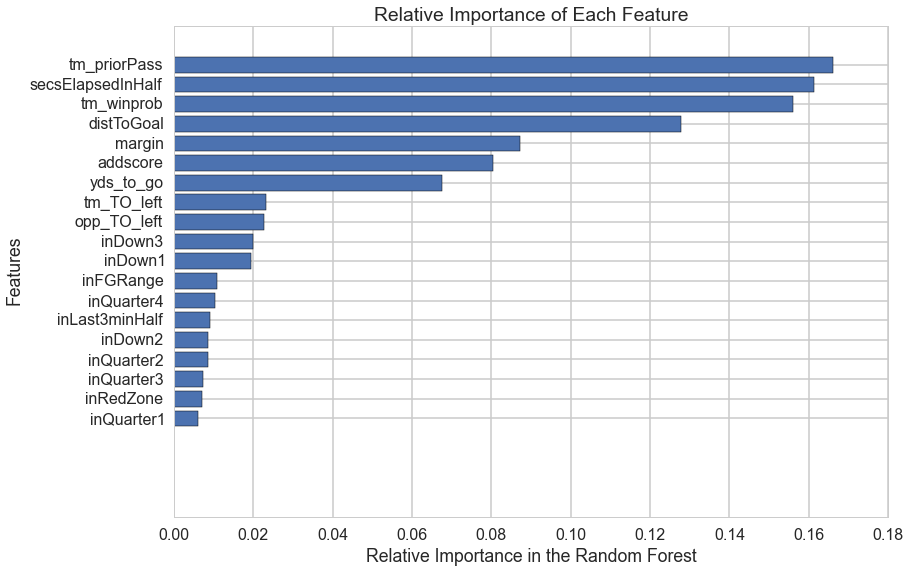

In [70]:
importance_list = clfForest.feature_importances_
name_list = lcols
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative Importance of Each Feature')
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

clfAda = AdaBoostClassifier(base_estimator=clfForest)

parameters = {"n_estimators": range(1, 20)}
clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda, parameters, df, lcols, u'RESP', 1, mask=mask, score_func='f1')

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clfGB = GradientBoostingClassifier()

parameters = {"n_estimators": range(1, 20)}
clfGB, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB, parameters, df, lcols, u'RESP', 1, mask=mask, score_func='f1')

In [71]:
def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired)
    plt.show()
    
    print type(X_train[:, 0].min()), type(plot_step)
    



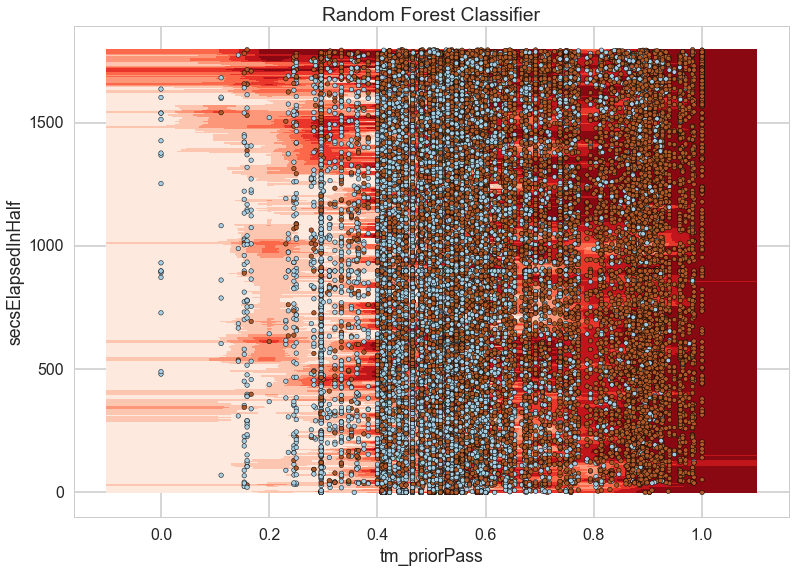

<type 'numpy.float64'> <type 'float'>


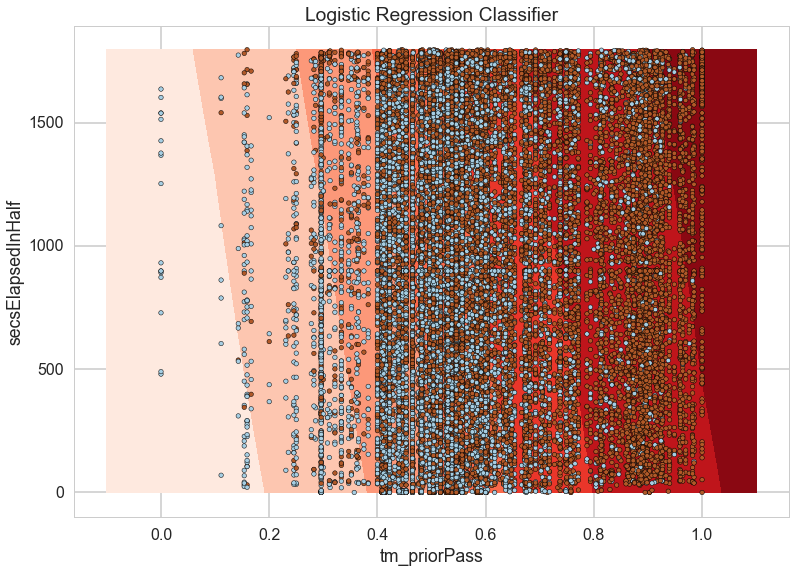

<type 'numpy.float64'> <type 'float'>


In [72]:
xt = [lcols[e] for e in clfForest.feature_importances_.argsort()[::-1][0:2]]
X_imp = df[xt].values
Y = df.RESP.values

classifiers = [clfForest, clflog]

titleClassifer = ['Random Forest Classifier', "Logistic Regression Classifier"]
for c in range(len(classifiers)):
    plt.title(titleClassifer[c])
    plt.xlabel(xt[0])
    plt.ylabel(xt[1])
    plot_decision_surface(classifiers[c], X_imp, Y)

In [ ]:
#ROC CURVES

In [36]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [80]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
        ax.grid(False)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
    ax.legend(loc="lower right")
    return ax

In [81]:
len(Xtest[0])

19

In [83]:
clfsvm_lin, Xtrainlin, ytrainlin, Xtestlin, ytestlin = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)

using mask
BEST {'C': 0.01} 0.619363180863 [mean: 0.57642, std: 0.05859, params: {'C': 0.001}, mean: 0.61936, std: 0.03469, params: {'C': 0.01}, mean: 0.57718, std: 0.03935, params: {'C': 0.1}, mean: 0.52966, std: 0.06745, params: {'C': 1}, mean: 0.57082, std: 0.05033, params: {'C': 10}, mean: 0.49987, std: 0.06457, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.624535
Accuracy on test data:     0.637335
[[ 662 2518]
 [ 367 4408]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


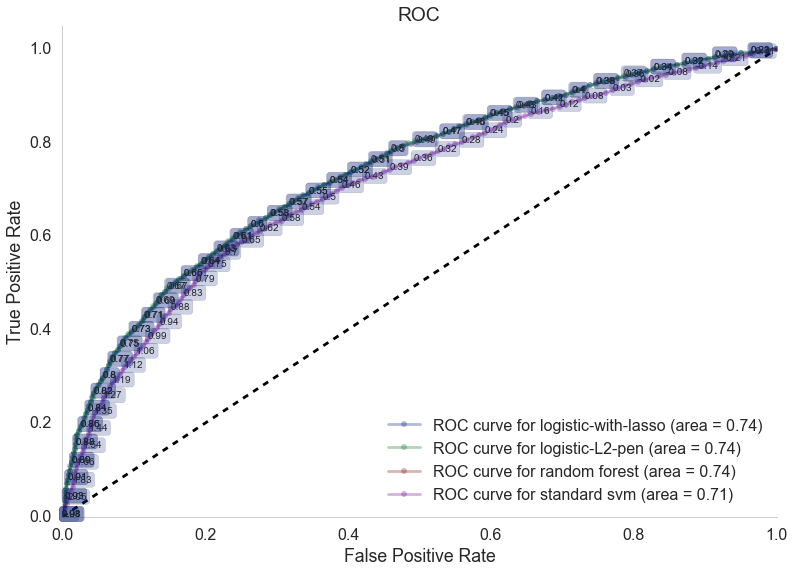

In [84]:
with sns.color_palette("dark"):
    ax=make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)
    make_roc("logistic-L2-pen",clflog2, ytest, Xtest, ax, labe=200, proba=True, skip=50);
    make_roc("random forest",clfForest, ytestfr, Xtestfr, ax, labe=200, proba=True, skip=50);
    make_roc("standard svm",clfsvm_lin, ytestlin, Xtestlin, ax, labe=200, proba=False, skip=50);


In [61]:
len(Xmatrix_train[0]) 
len(Xmatrix_test) 

7955

In [65]:
Yresp_test

array([1, 0, 0, ..., 0, 0, 1])

In [62]:
len(Yresp_train)

18561